In [1]:
from sklearnex import patch_sklearn; patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from transformers import (AutoModelForSequenceClassification, pipeline)
import transformers
import datasets
from tqdm import tqdm
# from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request
import pandas as pd
from tqdm import tqdm
from typing import Callable
from collections.abc import Iterable
import time
import seaborn as sns

/Users/elliotheisler/anaconda3/envs/cmpt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### format dataframes (could have done this in preprocessing notebook)

In [4]:
def format_reviews_df(df: pd.DataFrame): 
    df = df.copy()
    df['user_review'] = df['user_review'].fillna('').astype('string')
    df['title'] = df['title'].fillna('').astype('string')
    return df

def format_games_df(df: pd.DataFrame): 
    df = df.copy()
    df = df.astype({'title': 'string', 'developer': 'string',
               'publisher': 'string', 'tags': 'string',
               'overview': 'string'
              })
    return df
    
df = pd.read_csv('data/new_df.csv')
df = format_reviews_df(df)
df_games = pd.read_csv('data/train_gr/game_overview.csv')
df_games = format_games_df(df_games)

### merge game info columns from game_overview.csv

In [5]:
new_df = df.join(df_games.set_index('title'), on='title', lsuffix='_l', rsuffix='_r', validate='m:1')
new_df.tail(2)

,review_id,title,year,user_review,user_suggestion,is_early_access,received_free,contains_art,developer,publisher,tags,overview
17314,25536,EverQuest II,2017.0,"An older game, to be sure, but has its own cha...",1,False,False,False,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...
17315,25537,EverQuest II,2011.0,When I frist started playing Everquest 2 it wa...,1,False,False,False,Daybreak Game Company,Daybreak Game Company,"['Free to Play', 'Massively Multiplayer', 'RPG...",EverQuest® II is the epitome of massively mult...


### merge sentiment analysis columns. repeated 3 times.
- one for beginning, middle, and end of the reviews

In [7]:
SELECTION = 'left'
df_sentiments = pd.read_csv(f'data/results_{SELECTION}.csv')
new_df = pd.concat([new_df, df_sentiments], axis=1)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17316 entries, 0 to 17315
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   review_id        17316 non-null  int64  
 1   title            17316 non-null  string 
 2   year             17316 non-null  float64
 3   user_review      17316 non-null  string 
 4   user_suggestion  17316 non-null  int64  
 5   is_early_access  17316 non-null  bool   
 6   received_free    17316 non-null  bool   
 7   contains_art     17316 non-null  bool   
 8   developer        17316 non-null  string 
 9   publisher        17316 non-null  string 
 10  tags             17316 non-null  string 
 11  overview         17316 non-null  string 
 12  positive         17316 non-null  float64
 13  neutral          17316 non-null  float64
 14  negative         17316 non-null  float64
dtypes: bool(3), float64(4), int64(2), string(6)
memory usage: 1.6 MB


### take numeric columns, encode categorical columns

In [9]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
le = LabelEncoder()
oe = OrdinalEncoder().set_output(transform="pandas")

numeric_df = new_df.copy()
numeric_df = numeric_df.drop(['review_id', 'tags', 'overview', 'user_review'], axis=1) # TODO: add sentiment scores
# fit transforms for y and x
numeric_df['user_suggestion'] = le.fit_transform(numeric_df['user_suggestion'])
# x: string enums
numeric_df[['title', 'developer', 'publisher']] = \
    oe.fit_transform(numeric_df[['title', 'developer', 'publisher']])
# x: bools
numeric_df[['is_early_access', 'received_free', 'contains_art']] = \
    oe.fit_transform(numeric_df[['is_early_access', 'received_free', 'contains_art']])

### correlation matrix

<Axes: >

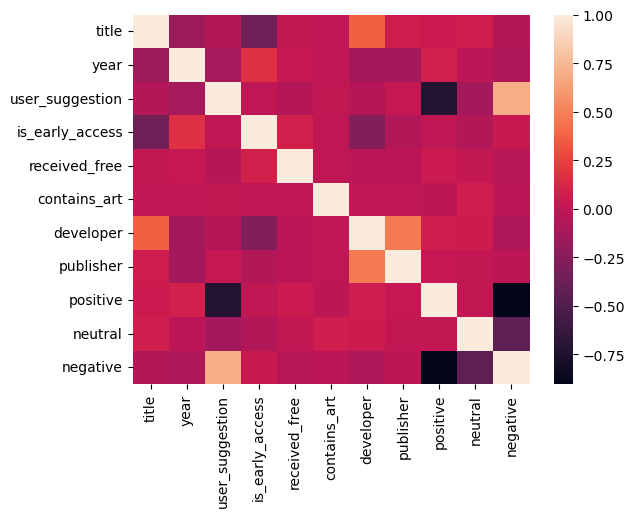

In [10]:
hm = numeric_df.corr()
sns.heatmap(hm)

### split x and y, selkbest, standardscaler, and finally train/testsplit

In [11]:
# x and y
y = numeric_df['user_suggestion']
x = numeric_df.drop('user_suggestion', axis=1)

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, r_regression
from sklearn.model_selection import train_test_split, GridSearchCV
# selkbest
skb = SelectKBest(score_func=chi2, k=5).set_output(transform='pandas')
best_x = skb.fit_transform(x, y)
sorted(skb_df.columns.to_list())

In [ ]:
# scaled
scaler = StandardScaler()
scaled_x = scaler.fit_transform(best_x)
scaled_x = pd.DataFrame(scaled_x, columns=best_x.columns)

x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.20)

### SVM grid search

In [27]:
from sklearnex.svm import SVC
svm_paramgrid = {
    'kernel': ['linear', 'rbf'],
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto'],
    'coef0': [0, -10, 10]
}
svm_classifier = SVC()
grid = GridSearchCV(svm_classifier, svm_paramgrid)

In [28]:
# %%timeit -n1 -r1
grid.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100], 'coef0': [0, -10, 10],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [29]:
y_pred = grid.predict(x_test)

<Axes: >

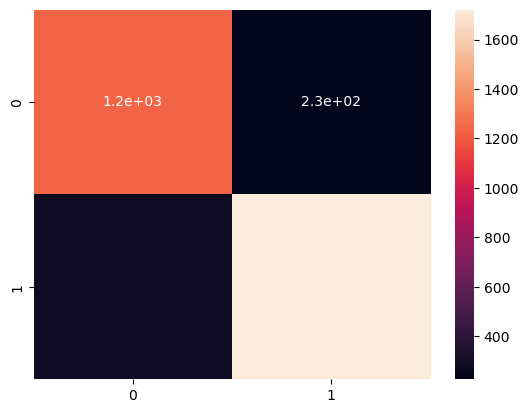

In [30]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True)

In [39]:
gs_df = pd.DataFrame(grid.cv_results_)
gs_df.sort_values(by='mean_test_score', ascending=False)
gs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_coef0,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,3.419530,0.177978,0.030706,0.002192,100,10,auto,rbf,"{'C': 100, 'coef0': 10, 'gamma': 'auto', 'kern...",0.852761,0.856370,0.852347,0.850542,0.855596,0.853523,0.002157,1
31,3.329402,0.180567,0.028497,0.000588,100,-10,auto,rbf,"{'C': 100, 'coef0': -10, 'gamma': 'auto', 'ker...",0.852761,0.856370,0.852347,0.850542,0.855596,0.853523,0.002157,1
27,3.414354,0.164790,0.030634,0.003201,100,0,auto,rbf,"{'C': 100, 'coef0': 0, 'gamma': 'auto', 'kerne...",0.852761,0.856370,0.852347,0.850542,0.855596,0.853523,0.002157,1
25,3.464845,0.233941,0.030474,0.002380,100,0,scale,rbf,"{'C': 100, 'coef0': 0, 'gamma': 'scale', 'kern...",0.852761,0.856009,0.852347,0.850181,0.855957,0.853451,0.002246,4
29,3.666030,0.232775,0.031577,0.000779,100,-10,scale,rbf,"{'C': 100, 'coef0': -10, 'gamma': 'scale', 'ke...",0.852761,0.856009,0.852347,0.850181,0.855957,0.853451,0.002246,4
33,3.316806,0.127720,0.028719,0.000374,100,10,scale,rbf,"{'C': 100, 'coef0': 10, 'gamma': 'scale', 'ker...",0.852761,0.856009,0.852347,0.850181,0.855957,0.853451,0.002246,4
23,1.665160,0.062864,0.029528,0.000647,10,10,auto,rbf,"{'C': 10, 'coef0': 10, 'gamma': 'auto', 'kerne...",0.849874,0.846265,0.849458,0.844043,0.848736,0.847675,0.002205,7
13,1.567158,0.062684,0.029800,0.000603,10,0,scale,rbf,"{'C': 10, 'coef0': 0, 'gamma': 'scale', 'kerne...",0.849874,0.846265,0.849458,0.844043,0.848736,0.847675,0.002205,7
21,1.591434,0.100210,0.030624,0.001929,10,10,scale,rbf,"{'C': 10, 'coef0': 10, 'gamma': 'scale', 'kern...",0.849874,0.846265,0.849458,0.844043,0.848736,0.847675,0.002205,7
19,1.697684,0.079720,0.030946,0.003458,10,-10,auto,rbf,"{'C': 10, 'coef0': -10, 'gamma': 'auto', 'kern...",0.849874,0.846265,0.849458,0.844043,0.848736,0.847675,0.002205,7
